In [89]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

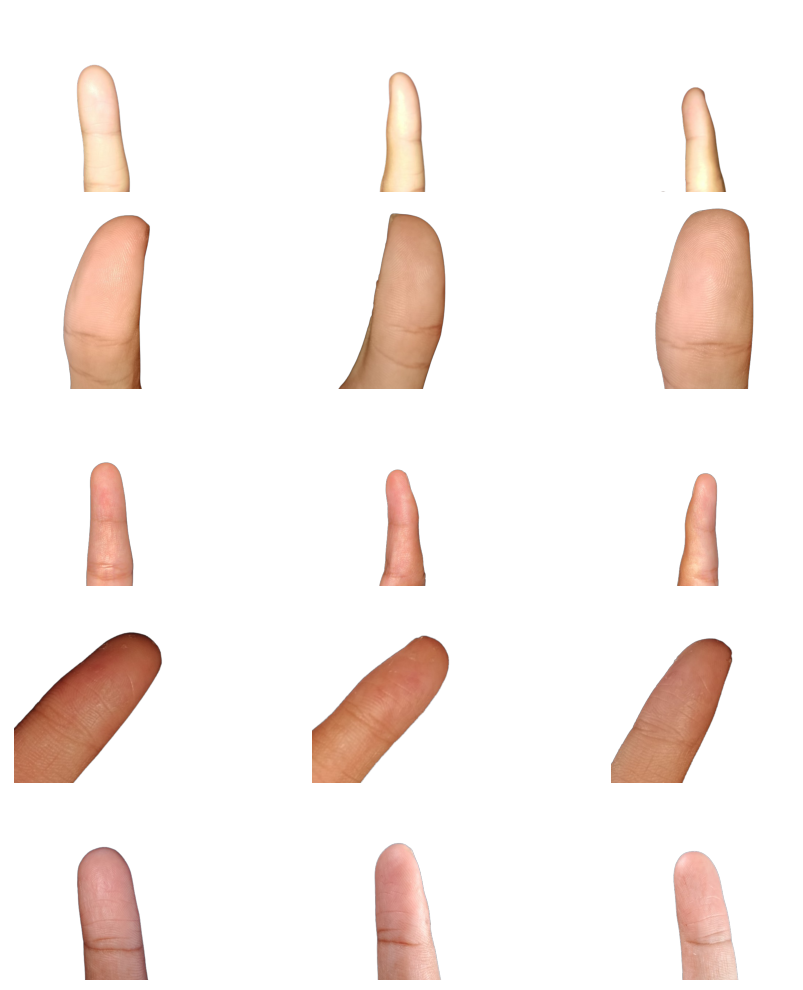

In [93]:
# Daftar nama folder yang berisi file gambar
folder_names = ['DataJari/krisko', 'DataJari/rama', 'DataJari/ryo','DataJari/satria', 'DataJari/yoga' ]  # Tambahkan folder lain sesuai kebutuhan

# Mengumpulkan semua file gambar dari setiap folder
image_files = []
for folder_name in folder_names:
    image_files.extend([os.path.join(folder_name, f) for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))])

# Menghitung jumlah gambar
num_images = len(image_files)

# Menentukan ukuran grid untuk menampilkan gambar (misalnya, 3x3 grid)
grid_size = (5, 3)

# Membuat subplots
fig, axes = plt.subplots(*grid_size, figsize=(10, 10))

# Menampilkan setiap gambar pada subplot yang sesuai
for idx, image_path in enumerate(image_files):
    if idx >= grid_size[0] * grid_size[1]:
        break  # Jika gambar lebih banyak dari grid, hentikan penambahan gambar
    
    img = mpimg.imread(image_path)
    
    # Menentukan posisi subplot
    ax = axes[idx // grid_size[1], idx % grid_size[1]]
    ax.imshow(img)
    ax.axis('off')  # Menghilangkan sumbu

for idx in range(num_images, grid_size[0] * grid_size[1]):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

In [91]:
def image_to_grayscale(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    width, height = image.size
    grayscale_array = np.zeros((height, width), dtype=np.uint8)
    
    pixels = image.load()
    for i in range(width):
        for j in range(height):
            r, g, b = pixels[i,j]
            grayscale_value = int((r + g + b) / 3)
            grayscale_array[j,i] = grayscale_value
    
    grayscale_image = Image.fromarray(grayscale_array, mode='L')
    return grayscale_image

In [82]:

# Daftar folder yang berisi gambar
folders = ["krisko", "rama", "ryo", "satria", "yoga"]

# Inisialisasi list untuk menyimpan fitur
features_list = []

# Loop untuk setiap folder
for folder in folders:
    print(f"Processing images in folder: {folder}")
    
    # Path ke folder input dan label
    folder_path = f"DataJari/{folder}/"
    label = folders.index(folder)
    
    # Loop untuk setiap gambar di dalam folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Baca gambar
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            
            # Konversi ke grayscale
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Thresholding menggunakan Otsu's thresholding
            _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            
            # Morphological closing untuk membersihkan hasil thresholding
            kernel = np.ones((3, 3), np.uint8)
            binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
            
            # Ekstraksi fitur dari gambar sidik jari yang sudah disegmentasi
            red_channel = img[:,:,0]
            green_channel = img[:,:,1]
            blue_channel = img[:,:,2]
            
            blue_channel[blue_channel == 255] = 0
            green_channel[green_channel == 255] = 0
            red_channel[red_channel == 255] = 0
            
            red_mean = np.mean(red_channel)
            green_mean = np.mean(green_channel)
            blue_mean = np.mean(blue_channel)
            
            red_std = np.std(red_channel)
            green_std = np.std(green_channel)
            blue_std = np.std(blue_channel)
            
            glcm_matrix = graycomatrix(gray_image, [1], [0], levels=256, symmetric=True, normed=True)
            
            contrast = graycoprops(glcm_matrix, 'contrast')[0, 0]
            dissimilarity = graycoprops(glcm_matrix, 'dissimilarity')[0, 0]
            
            # Menyimpan fitur ke dalam list
            features = [red_std, green_std, blue_std, red_mean, green_mean, blue_mean, contrast, dissimilarity, label]
            features_list.append(features)

# Buat DataFrame dari fitur-fitur yang sudah diekstraksi
columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y']
df = pd.DataFrame(features_list, columns=columns)

# Simpan ke file CSV
output_file = "Training.csv"
df.to_csv(output_file, index=False)

# Cetak DataFrame untuk memverifikasi
print("DataFrame saved to:", output_file)
print(df.head())


Processing images in folder: krisko
Processing images in folder: rama
Processing images in folder: ryo
Processing images in folder: satria
Processing images in folder: yoga
DataFrame saved to: Training.csv
          X1         X2          X3         X4         X5         X6  \
0  66.250336  76.536752   81.738707  27.779733  32.327469  31.690283   
1  58.105828  68.769388   72.801124  21.370652  25.318638  24.969127   
2  51.490610  60.812304   68.090553  17.417203  20.606245  22.168093   
3  66.875886  80.851337  106.253366  47.658664  58.649364  74.381788   
4  56.738239  71.996541   96.660644  40.470712  52.139796  70.598280   

          X7        X8  Y  
0  71.145833  0.920933  0  
1  52.596890  0.872965  0  
2  47.558836  0.739958  0  
3  49.705980  1.346838  1  
4  23.828625  0.918581  1  


In [83]:
from sklearn.model_selection import train_test_split

# Membaca file CSV yang berisi fitur dan label
df = pd.read_csv("Training.csv")

# Memisahkan fitur (X) dan label (Y)
X = df.drop('Y', axis=1)  # Memilih semua kolom kecuali kolom 'Y' sebagai fitur
y = df['Y']  # Kolom 'Y' sebagai label

# Membagi data menjadi training dan testing dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Simpan data training ke CSV
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv("Training_split.csv", index=False)

# Simpan data testing ke CSV
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv("Testing_split.csv", index=False)

print("Data training dan testing sudah dibagi dalam CSV.")


Data training dan testing sudah dibagi dalam CSV.


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pickle  # Impor pickle untuk menyimpan model

# Memuat data dari file CSV (asumsi nama file yang sesuai)
X_train = pd.read_csv("Training_split.csv").drop('Y', axis=1)
y_train = pd.read_csv("Training_split.csv")['Y']
X_test = pd.read_csv("Testing_split.csv").drop('Y', axis=1)
y_test = pd.read_csv("Testing_split.csv")['Y']

# Skala fitur (opsional, tetapi direkomendasikan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buat model LogisticRegression
model = LogisticRegression(max_iter=1000)  # Iterasi yang ditingkatkan untuk ketahanan

try:
  # Latih model pada data yang diskalakan
  model.fit(X_train_scaled, y_train)

except ConvergenceWarning:
  print("ConvergenceWarning: Model mungkin tidak terkonvergensi dengan sempurna.")
  # Anda mungkin ingin mencoba penyesuaian lebih lanjut di sini (misalnya, solver berbeda)

# Evaluasi performa model
y_pred = model.predict(X_test_scaled)
akurasi = accuracy_score(y_test, y_pred)
print(f"Akurasi model: {akurasi}")

# Simpan model yang telah dilatih
pickle.dump(model, open("model_sidik_jari.pkl", "wb"))


Akurasi model: 0.6666666666666666


In [85]:
import joblib
from sklearn import svm

# Function to train SVM classifier
def train_classifier(X_train, y_train):
    clf = svm.SVC(kernel="rbf", C=50)
    clf.fit(X_train, y_train)
    return clf

# Function to save trained model
def save_classifier(clf, model_path):
    joblib.dump(clf, model_path)

# Function to load trained model
def load_classifier(model_path):
    clf = joblib.load(model_path)
    return clf

# Example usage
if __name__ == "__main__":
    # Train or load SVM model
    train_model = False  # Set to True if you want to train the model
    model_path = "model_sidik_jari.pkl"

    if train_model:
        # Example code for training model
        X_train = [...]  # Your training data
        y_train = [...]  # Your training labels
        clf = train_classifier(X_train, y_train)
        save_classifier(clf, model_path)
        print("Model trained and saved.")

    else:
        # Load trained model
        clf = load_classifier(model_path)
        print("Model loaded successfully.")

    # Example fingerprint image (replace with your input method)
    fingerprint_image = cv2.imread("DataJari/yoga/yoga3.png")  # Example image
    
    # Example feature extraction (replace with your actual feature extraction code)
    features = extract_features_from_fingerprint(fingerprint_image)
    features = [features]  # Reshape features if needed
    
    # Example prediction
    prediction = clf.predict(features)
    print("Prediction:", prediction)


Model loaded successfully.
Prediction: [1]
